In [1]:
#ViT
import numpy as np
import pandas as pd
from memory_profiler import memory_usage

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split
#from transformers import ViTFeatureExtractor, ViTForImageClassification

import random
from PIL import Image, ImageOps
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.style.use('dark_background')

#If using script on terminal
#from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
num_workers = 0
script = False

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images,  train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data,train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


In [6]:
model = ViTBase16(n_classes=9, pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

name = 'Experiments/exp_56/model.pt'#'model.pt'#'other.pt' 
model = torch.load(name, map_location=torch.device('cpu'))

In [7]:
# Real lenses
path_cutouts = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/real_lenses/Jack_Y6/'

hdu_list = fits.open(path_cutouts + 'Cutouts/Jack_Y6.fits')
lenses = hdu_list[1].data.astype(np.float32)
data_pos = hdu_list[2].data
data_pos = Table(data_pos)
data_pos = data_pos.to_pandas()
#data_pos = data_pos.drop(['TILENAME', 'Candidate'], axis=1)
columns_data = data_pos.columns
hdu_list.close()
print('All sample: ', len(lenses))

data_not = pd.read_csv(path_cutouts + 'not_in_cutouts.csv')
data_not = data_not.astype({'COADD_OBJECT_ID': int})

new_data = pd.merge(data_pos, data_not, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
lenses = lenses[new_data.index]
data_pos = data_pos.iloc[new_data.index].reset_index()

dataset = ImageDataset(lenses, data_pos, np.zeros(len(lenses), dtype = np.int64), transform=transform)
print('With lensing features inside of cutout: ', len(dataset))

All sample:  246
With lensing features inside of cutout:  140


In [8]:
def search(dataset):
    prob_list = []
    search_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, num_workers=num_workers, shuffle=True)
    images = len(categories)*[np.zeros((1,3,45,45))]
    all_data = len(categories)*[pd.DataFrame()]
    
    for i_batch, sample in enumerate(tqdm(search_loader)):
        #if(i_batch==20): break
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
        
        output = model(sample_image)
    
        prob = nn.Softmax(dim=1)(output)
        prob_list.append(prob[:,0].detach().cpu().numpy()[0])
        i = prob.argmax(dim=1)
        
        new_df = pd.DataFrame(sample_data, columns=columns_data)
        #new_df['Prob'] = prob[:,i].detach() #prob that it belongs to the labeled category
        new_df['Prob'] = prob[:,0].detach() #prob that it's classified as positive
        all_data[i] = all_data[i].append(new_df, ignore_index=True)
        images[i] = np.append(images[i], np.array(sample_img), axis = 0)
    
    for i in range(len(categories)):
        images[i] = np.delete(images[i], 0, axis = 0)
    
    return(images, all_data, prob_list)

In [9]:
categories = ['Positives', 'Rings', 'Smooth', 'Companion', 'SDSS', 'DES_spirals', 'Crowded', 'Errors', 'Most_negatives']
images, all_data, prob_list = search(dataset)

right_data = all_data[0]
wrong_data = pd.DataFrame(columns=columns_data)

for i in range(len(all_data)):
    if(i == 0): continue
    wrong_data = wrong_data.append(all_data[i])

  0%|          | 0/140 [00:00<?, ?it/s]

In [10]:
#Default threshold of probability
n_out = len(right_data[right_data['einstein_radius'] >= 6]) + len(wrong_data[wrong_data['einstein_radius'] >= 6])
print('Total: {}, with Einstein radius > 6: {}'.format(len(lenses), n_out))
print('Detected: {}, not detected: {} \n'.format(len(right_data), len(wrong_data)))

print('Not identified lenses with Einstein radius > 6: ' + str(len(wrong_data[wrong_data['einstein_radius'] >= 6])))
print('Identified lenses with Einstein radius > 6: ' + str(len(right_data[right_data['einstein_radius'] >= 6])))
print(' ')

for i in range(len(images)):
    print('Labeled as {}: {}'.format(categories[i], len(images[i])))

    
print(' ')
ind = right_data[right_data['Prob'] > 0.75].index
print('Detected with a 0.75 threshold: '+ str(len(ind)))
ind = right_data[right_data['Prob'] > 0.8].index
print('Detected with a 0.8 threshold: '+ str(len(ind)))

Total: 140, with Einstein radius > 6: 17
Detected: 98, not detected: 42 

Not identified lenses with Einstein radius > 6: 10
Identified lenses with Einstein radius > 6: 7
 
Labeled as Positives: 98
Labeled as Rings: 3
Labeled as Smooth: 2
Labeled as Companion: 5
Labeled as SDSS: 2
Labeled as DES_spirals: 1
Labeled as Crowded: 7
Labeled as Errors: 0
Labeled as Most_negatives: 22
 
Detected with a 0.75 threshold: 86
Detected with a 0.8 threshold: 85


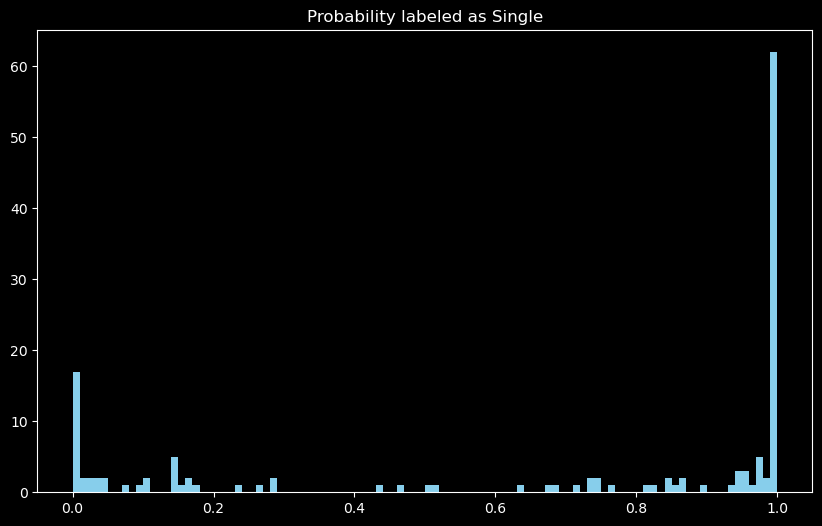

In [11]:
plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob_list, 100, color = "skyblue")
plt.show()

In [12]:
def write_fit_file(name, x, data):
    my_types = {'COADD_OBJECT_ID': int, 'TILENAME': str, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': float, 'IMAFLAGS_ISO_R': float, 'IMAFLAGS_ISO_I': float,
       'IMAFLAGS_ISO_Z': float, 'rank': int, 'num_sources': int, 'num_lenses': int, 'mem_match_id': int,
       'einstein_radius': float, 'einstein_radius_err': float, 'ACT': int, 'BBNA': int, 'BNA': int, 'TI': int,
       'RNA': int, 'RNA2': int, 'redM': float, 'redM_missed': float, 'SPTPol': float, 'Prob': float}
    data = data.astype(my_types)
    
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto(name + '.fits', overwrite=True)   
    hdu_list.close()

In [13]:
def make_plot_all(objects, data):
    
    for i in range(len(objects)):
        if(i%4 == 0):
            plt.figure(figsize=(10,6))
            for j in range(4):
                if(i+j > len(objects)-1): break
                plt.subplot(1,4,j+1)
                title = 'Prob: {:.3f}, rank: {}'.format(data['Prob'].values[i+j], int(data['rank'].values[i+j]))
                #print(data['COADD_OBJECT_ID'].values[i+j])
                #print(data['Prob'].values[i+j], int(data['rank'].values[i+j]))
                plt.title(title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show()

Not identified 

Rings


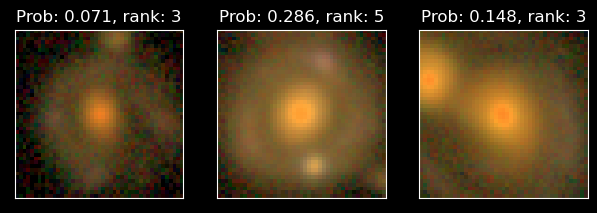

 
Smooth


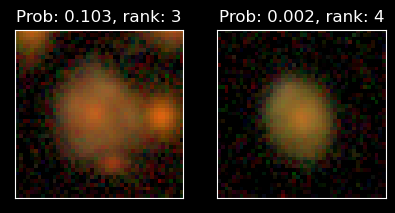

 
Companion


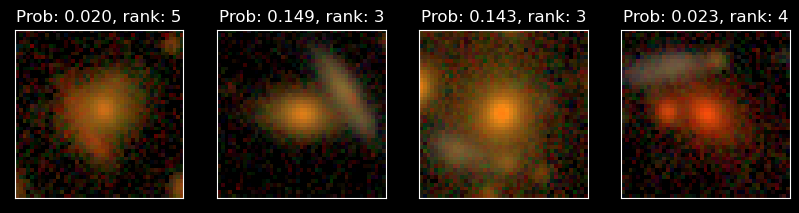

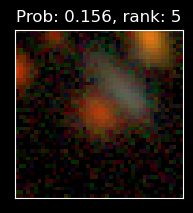

 
SDSS


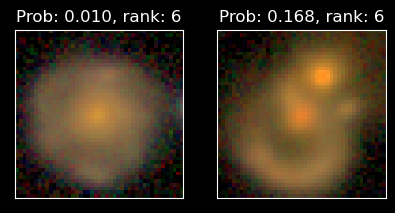

 
DES_spirals


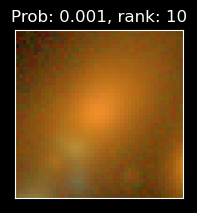

 
Crowded


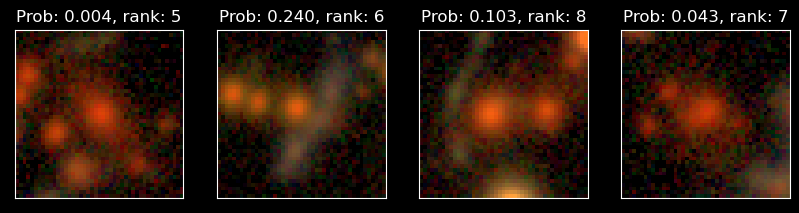

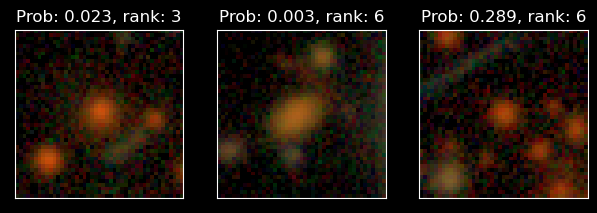

 
Errors
 
Most_negatives


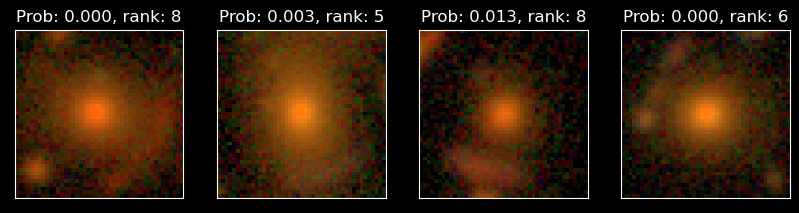

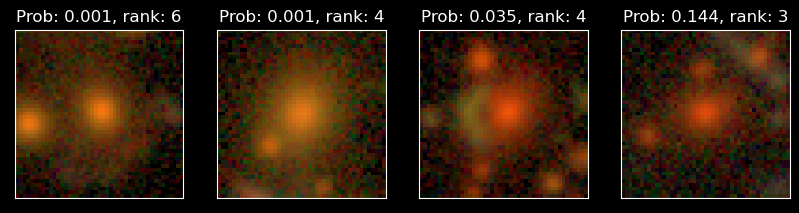

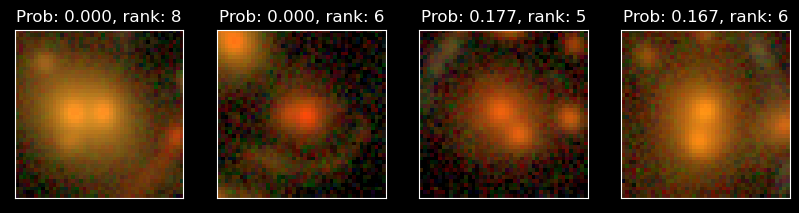

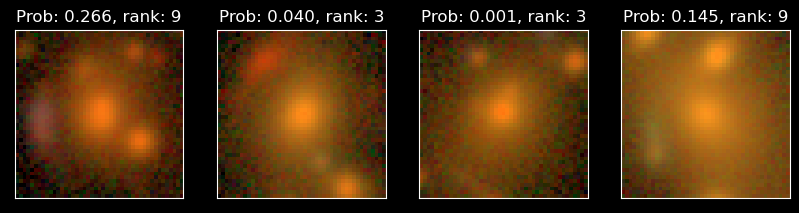

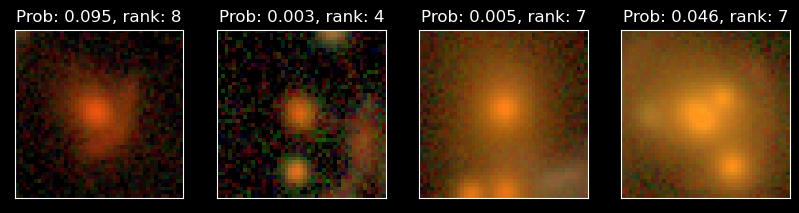

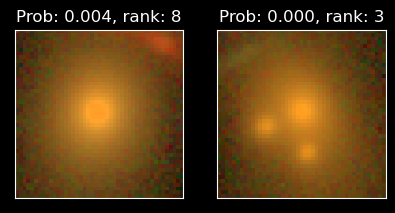

In [14]:
print('Not identified \n')
for i in range(1, len(categories)):
    print(categories[i])
    if(len(images[i]) == 0): 
        print(' ')
        continue
    make_plot_all(images[i], all_data[i])
    print(' ')

Identified 

Positives


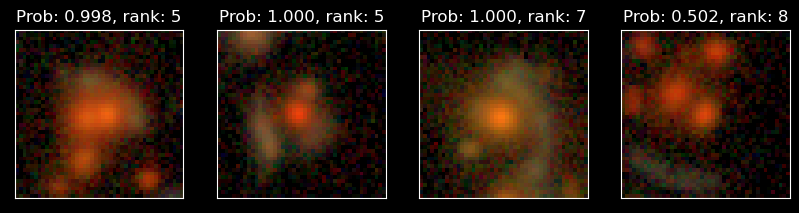

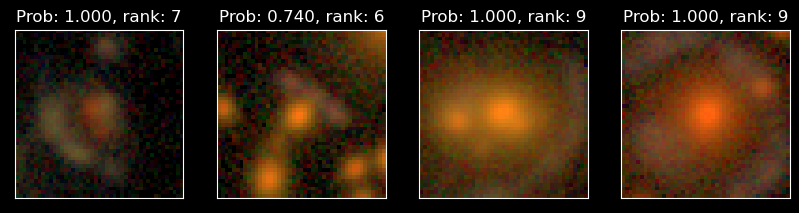

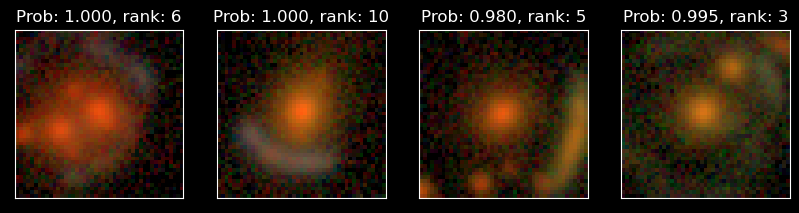

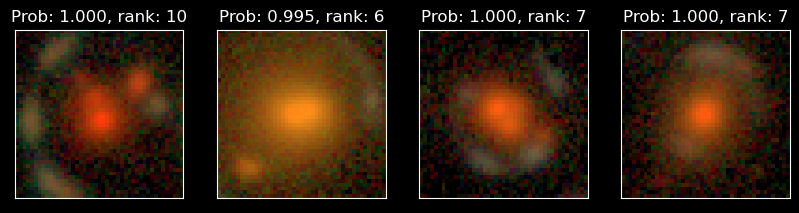

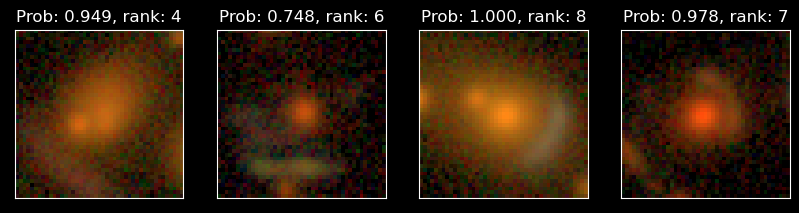

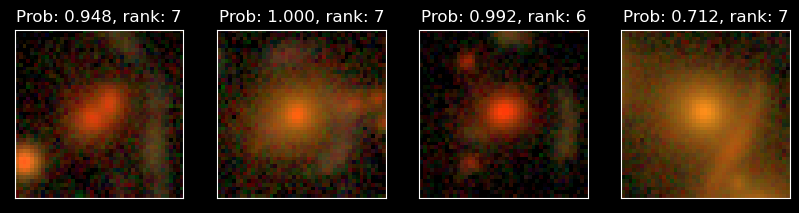

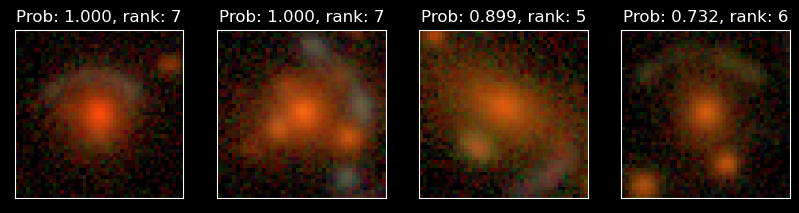

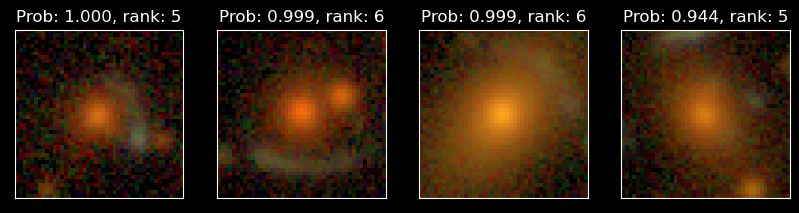

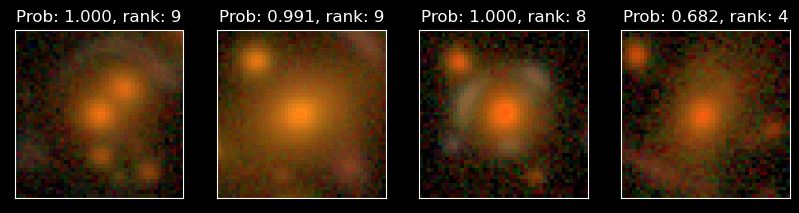

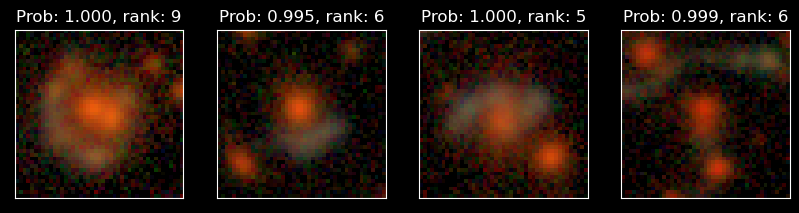

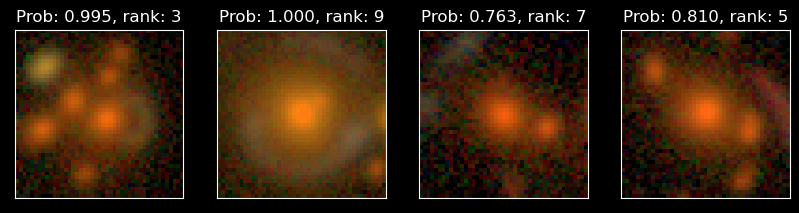

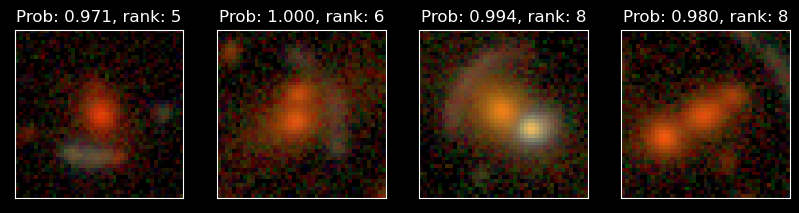

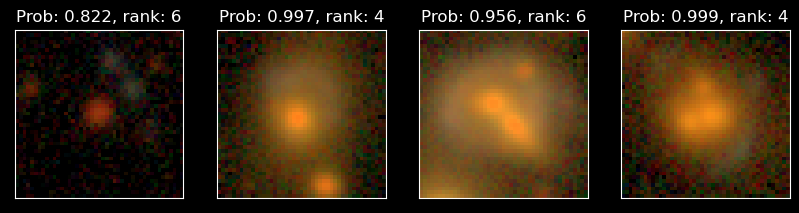

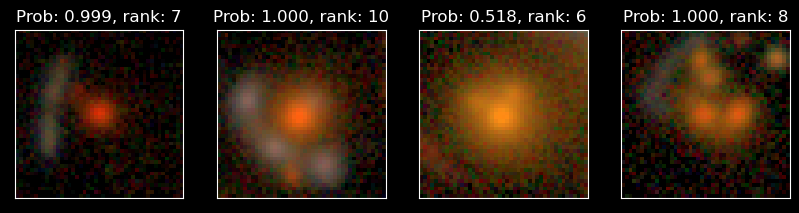

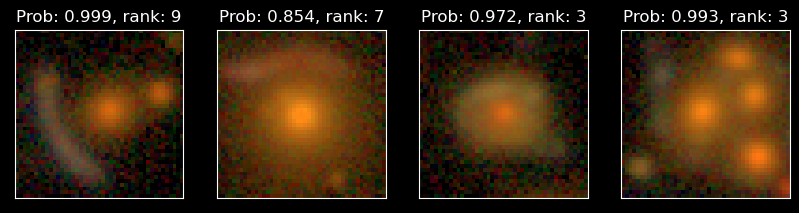

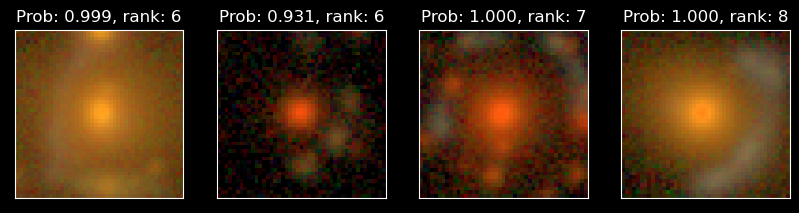

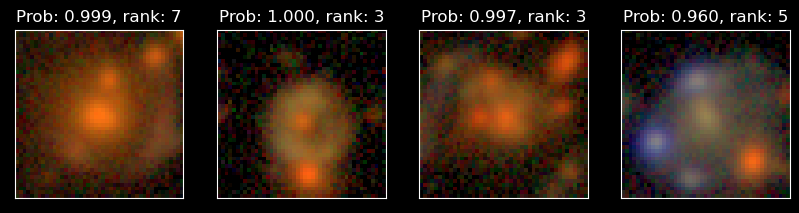

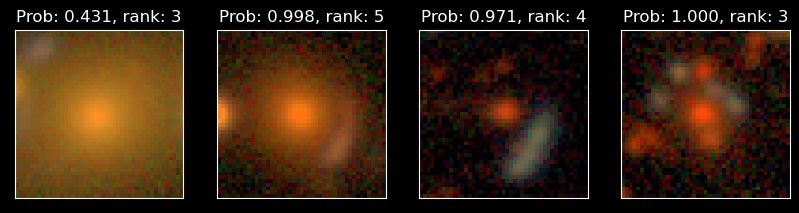

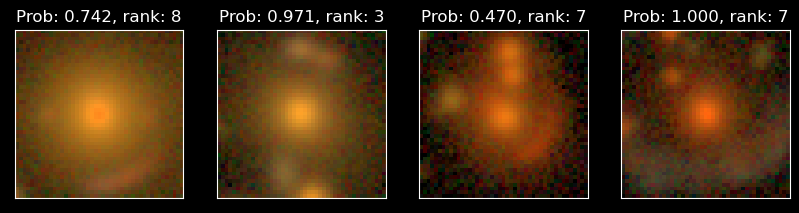

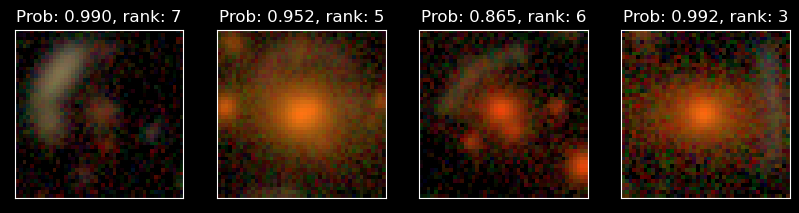

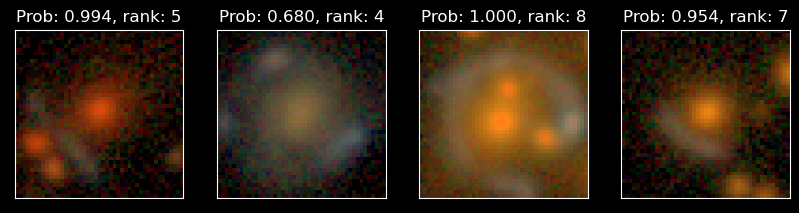

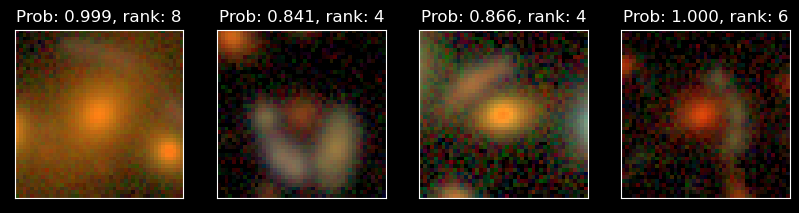

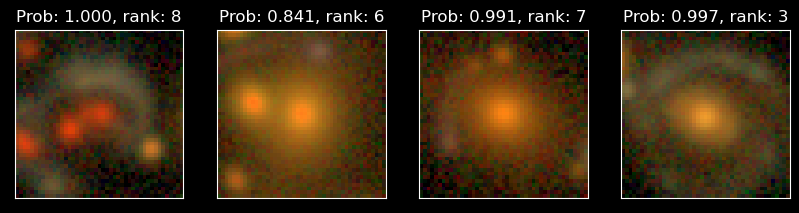

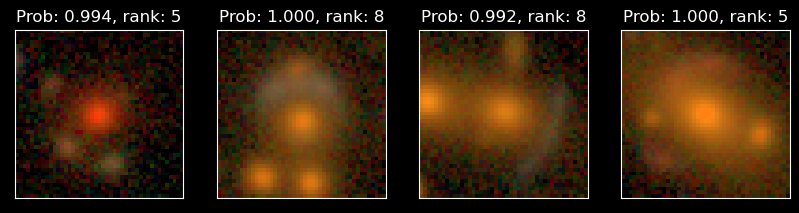

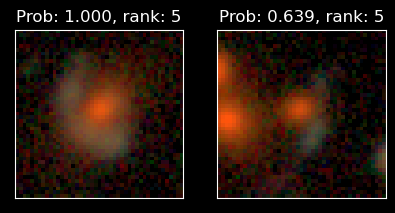

In [15]:
#Identified
print('Identified \n')
print(categories[0])
make_plot_all(images[0], all_data[0])

Identified with E > 6 

Positives


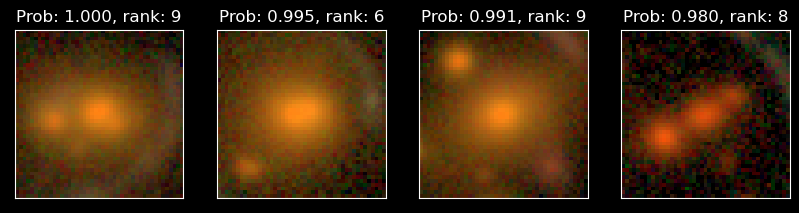

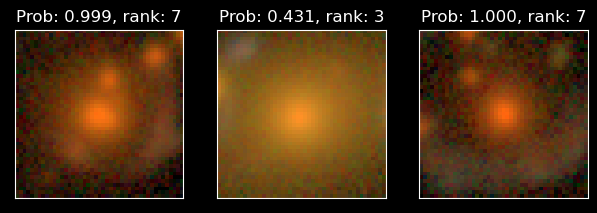

In [16]:
#Identified with E > 6
print('Identified with E > 6 \n')
print(categories[0])
ind = all_data[0][all_data[0]['einstein_radius'] > 6 ].index
make_plot_all(images[0][ind], all_data[0].iloc[ind])

In [17]:
names = ['Prob', 'einstein_radius', 'DNF_ZMEAN_SOF', 'rank', 'FLUX_RADIUS_G', 'KRON_RADIUS', 'GAP_FLUX_G',
         'MAG_AUTO_G', 'MAG_APER_4_G', 'MAG_APER_8_G', 'num_sources', 'num_lenses', 
         'einstein_radius_err']
print(len(names))
right_data = right_data[right_data['MAG_AUTO_G'] < 50]
wrong_data = wrong_data[wrong_data['MAG_AUTO_G'] < 50]

13


In [18]:
def make_histo(name):
    plt.figure(figsize=(16,5)) 
    
    plt.subplot(1,2,1)
    plt.title('All distribution: ' + str(name))
    data_all = np.concatenate((right_data[name], wrong_data[name]))
    #plt.hist(data_all, density = True, bins = 'auto', edgecolor = 'black')
    if(name == 'rank'): 
        plt.hist(data_all, bins = 7, edgecolor = 'black')
    else:
        plt.hist(data_all, bins = 'auto', edgecolor = 'black')
    
    if (name == 'rank'):
        plt.subplot(1,2,2)
        plt.title(name)
        plt.hist(right_data[name], bins = 7, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
        plt.hist(wrong_data[name], bins = 7, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
        plt.legend()
    else:
        plt.subplot(1,2,2)
        plt.title(name)
        #plt.hist(right_data[name], density = True, bins = 'auto', color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
        #plt.hist(wrong_data[name], density = True, bins = 'auto', color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
        plt.hist(right_data[name], bins = 'auto', color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
        plt.hist(wrong_data[name], bins = 'auto', color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
        plt.legend()
    
    plt.show()
        

def make_all_histos():
    for name in names:
        make_histo(name)

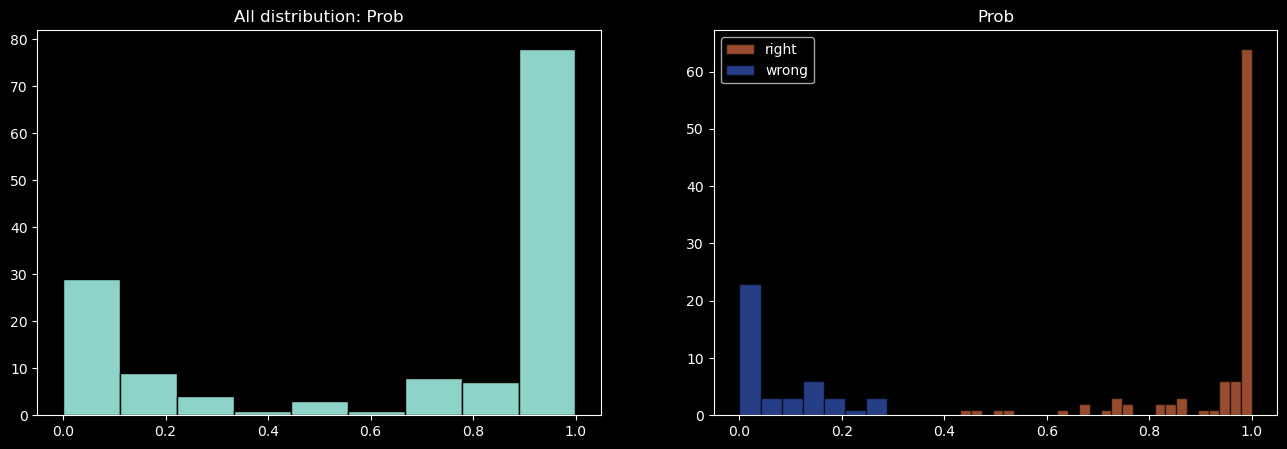

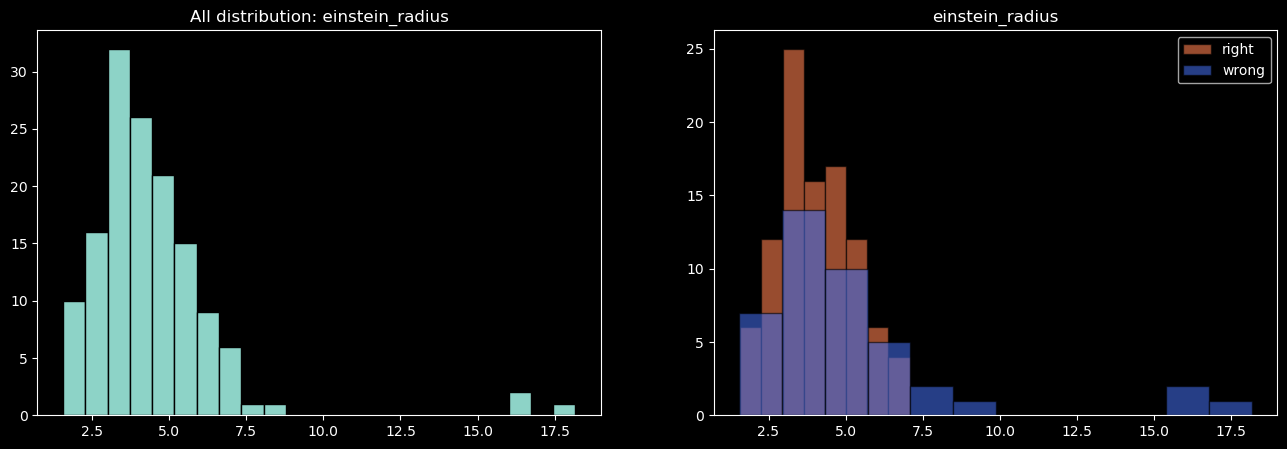

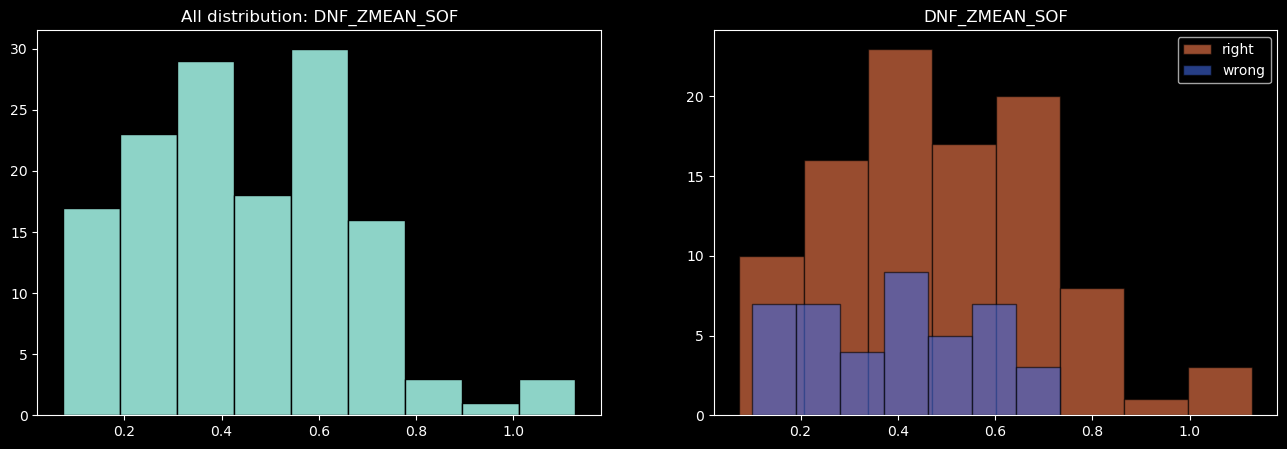

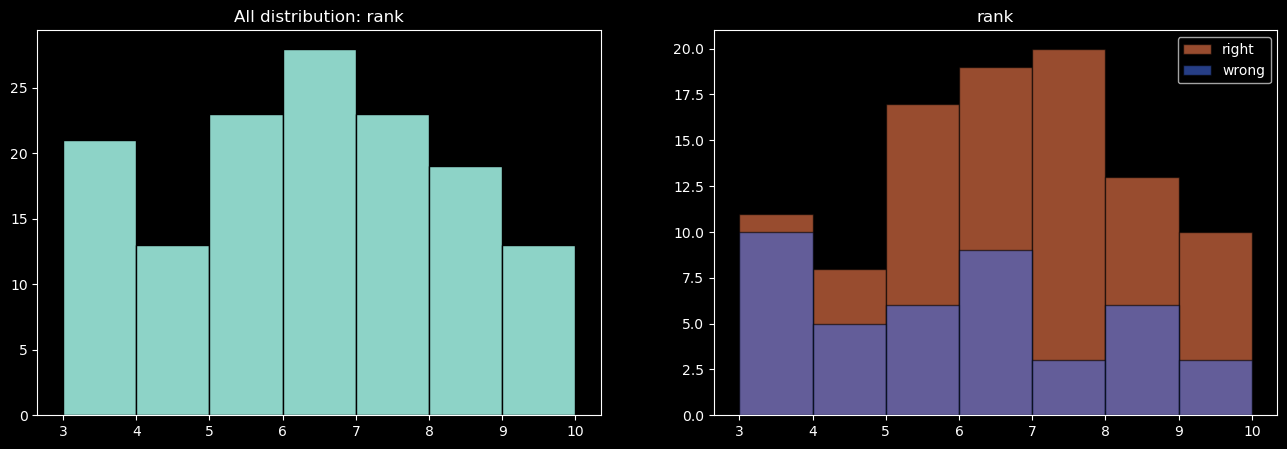

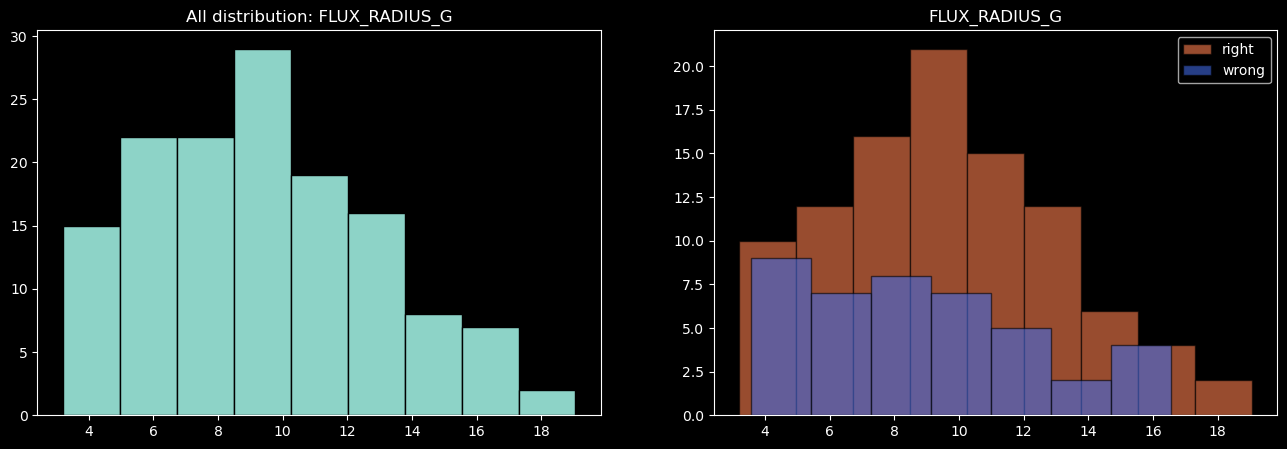

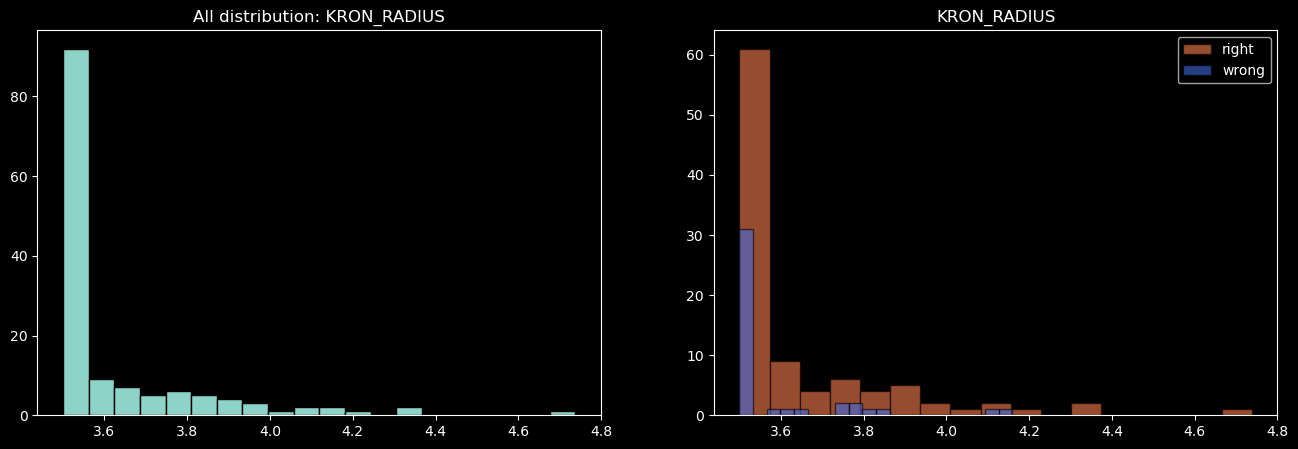

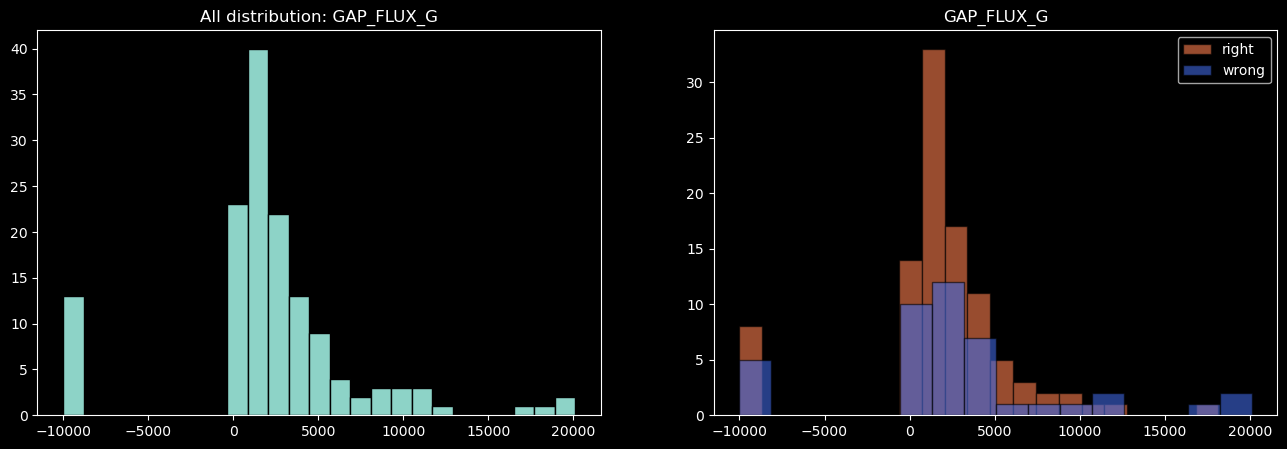

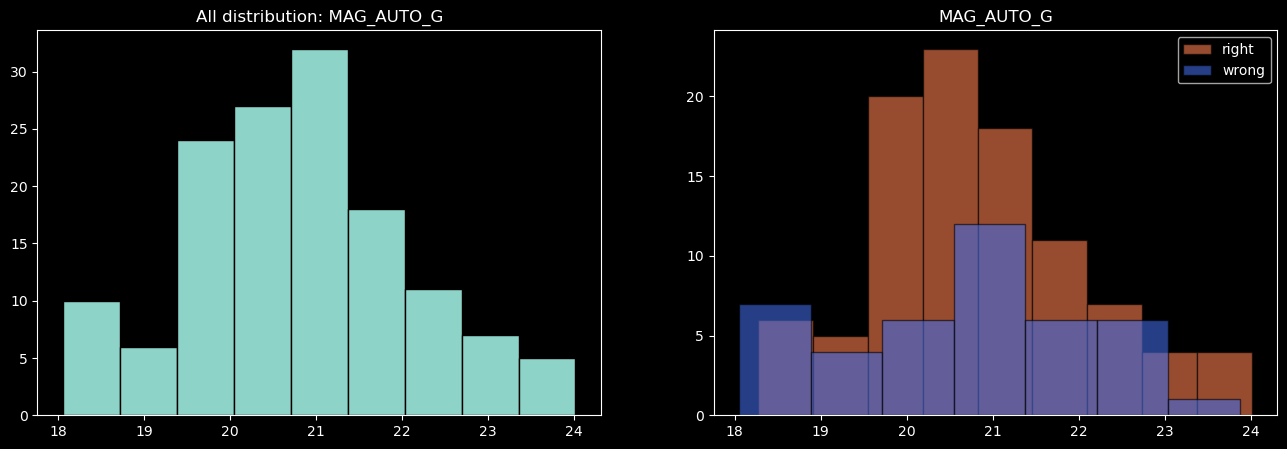

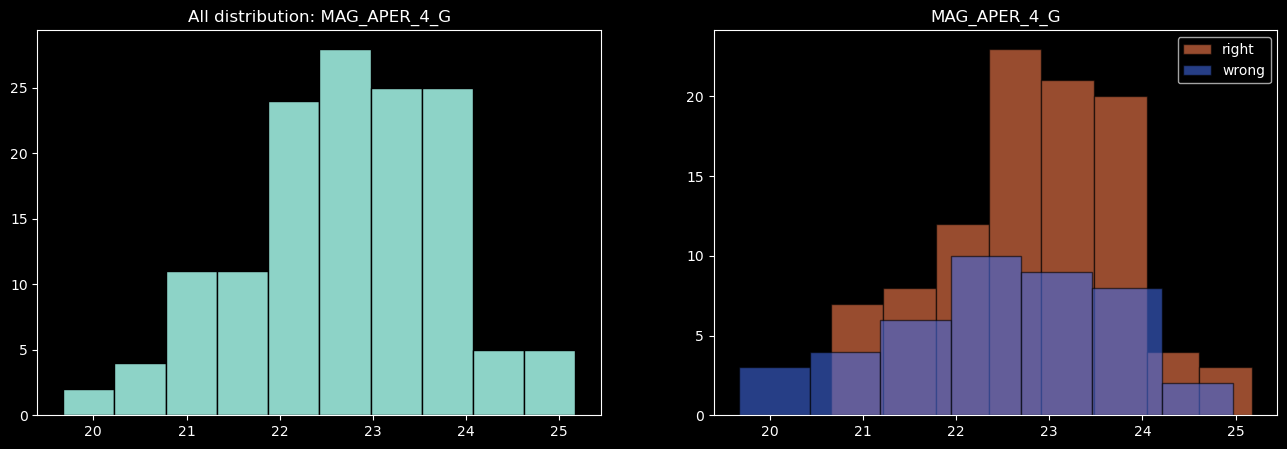

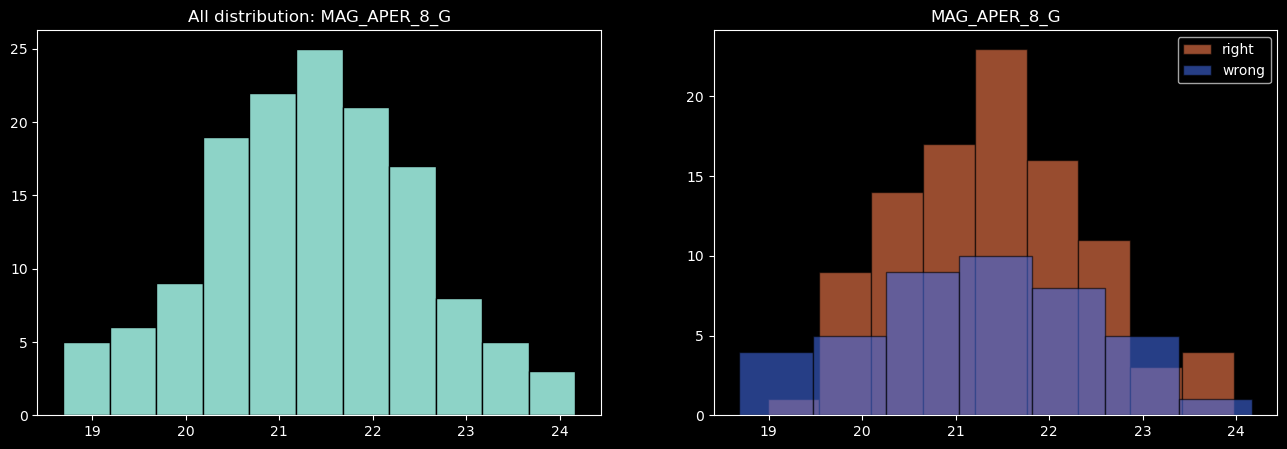

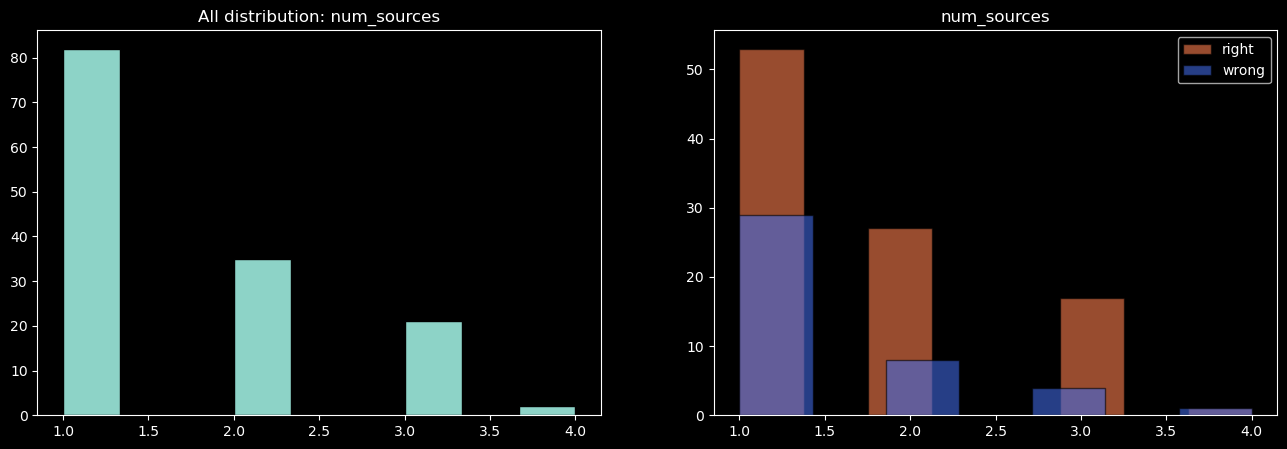

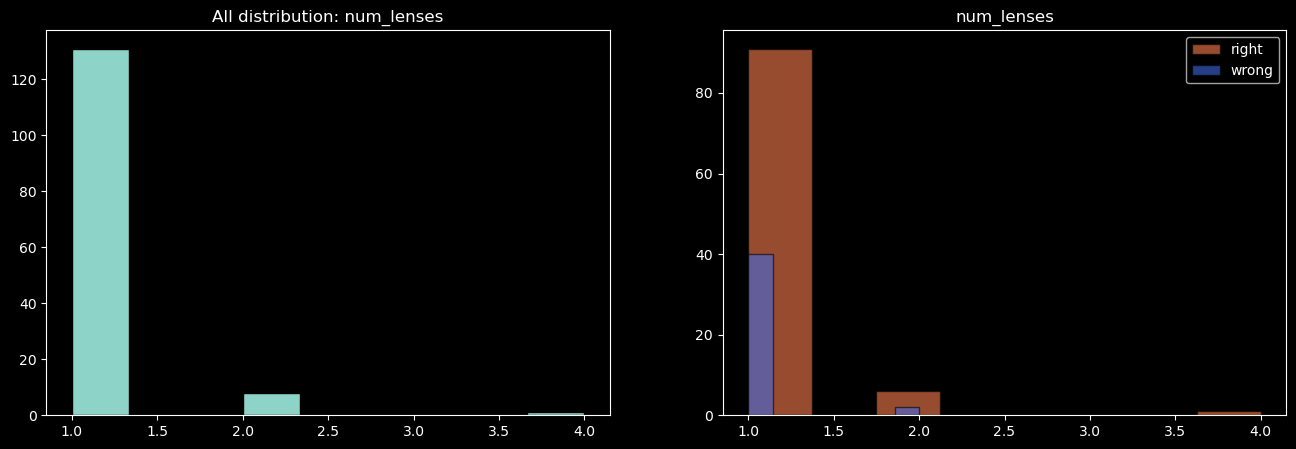

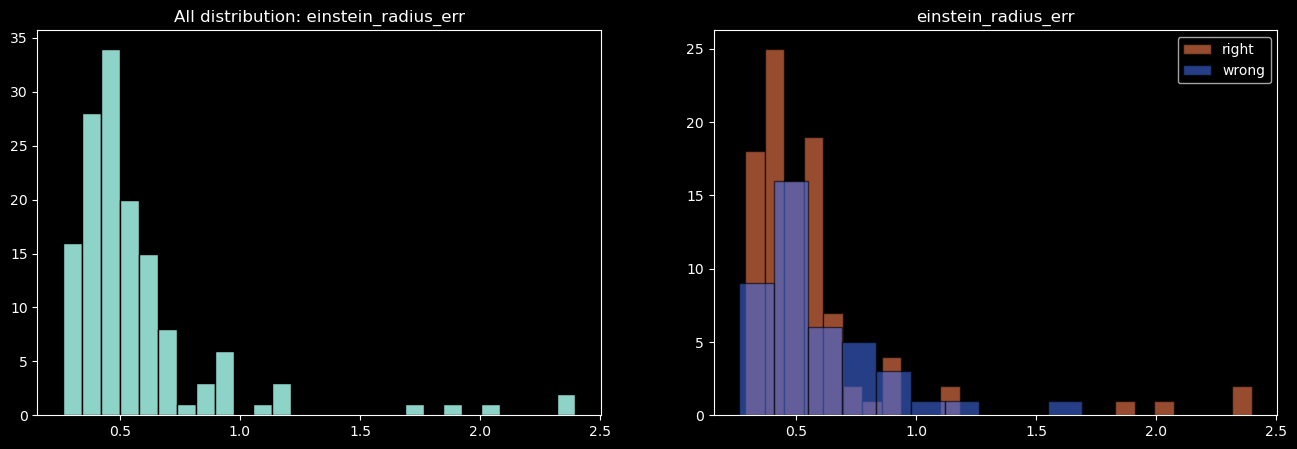

In [19]:
make_all_histos()

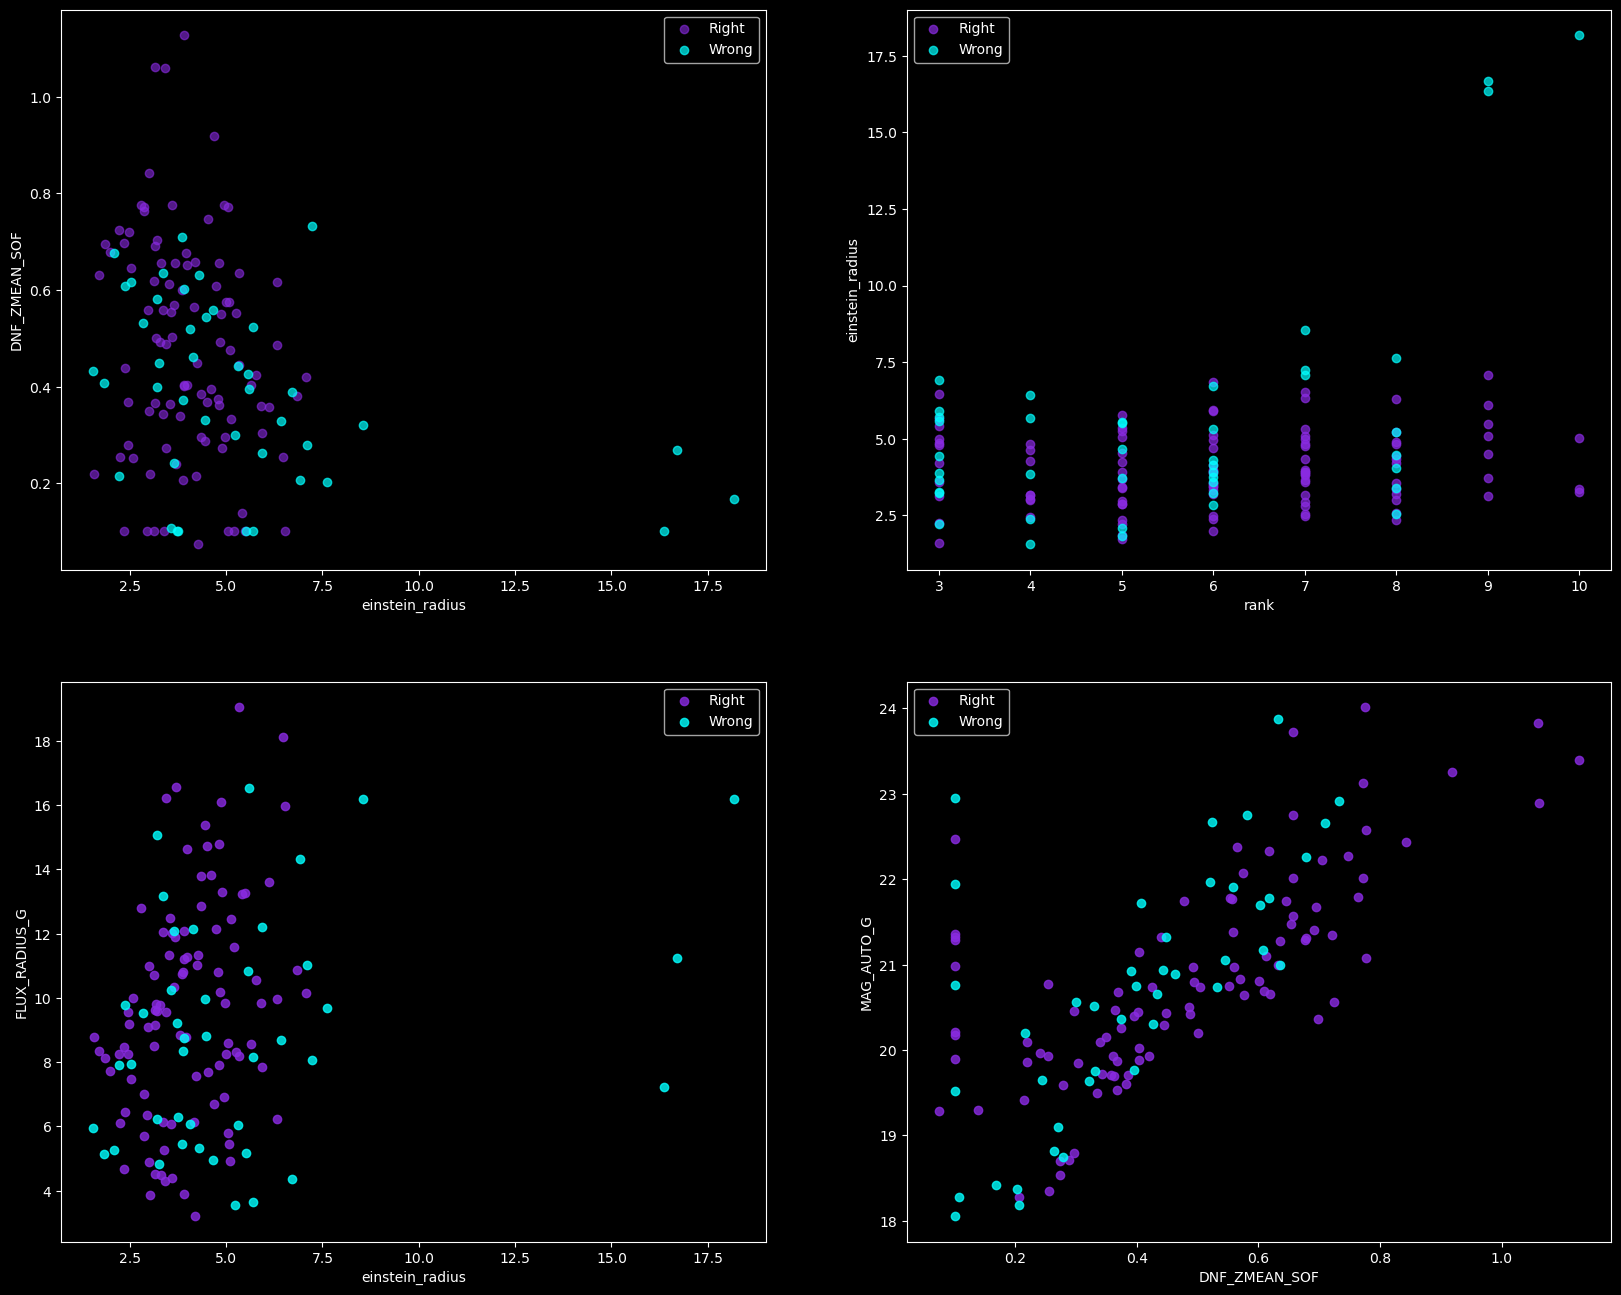

In [20]:
plt.figure(figsize=(20,16)) 

plt.subplot(2,2,1)
plt.xlabel(names[1])
plt.ylabel(names[2])
plt.scatter(right_data[names[1]], right_data[names[2]], color = 'blueviolet', alpha = 0.6, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[2]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel(names[3])
plt.ylabel(names[1])
plt.scatter(right_data[names[3]], right_data[names[1]], color = 'blueviolet', alpha = 0.7, label ='Right')
plt.scatter(wrong_data[names[3]], wrong_data[names[1]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel(names[1])
plt.ylabel(names[4])
plt.scatter(right_data[names[1]], right_data[names[4]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[4]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(2,2,4)
plt.xlabel(names[2])
plt.ylabel(names[7])
plt.scatter(right_data[names[2]], right_data[names[7]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[2]], wrong_data[names[7]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 
    
plt.show()

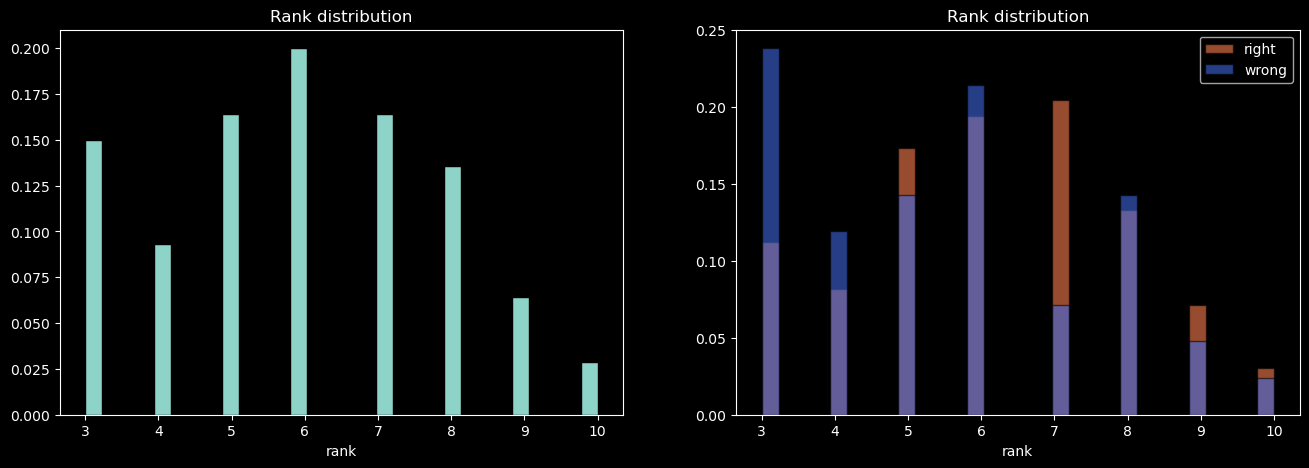

In [21]:
i=3

plt.figure(figsize=(16,5)) 

plt.subplot(1,2,1)
plt.title('Rank distribution')
plt.xlabel(names[i])
data_all = np.concatenate((right_data[names[i]], wrong_data[names[i]]))
weights = np.ones_like(data_all) / len(data_all)
plt.hist(data_all, 30, weights = weights, edgecolor = 'black')

plt.subplot(1,2,2)
plt.title('Rank distribution')
plt.xlabel(names[i])
weights = np.ones_like(right_data[names[i]]) / len(right_data[names[i]])
plt.hist(right_data[names[i]], 30, weights = weights, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
weights = np.ones_like(wrong_data[names[i]]) / len(wrong_data[names[i]])
plt.hist(wrong_data[names[i]], 30, weights = weights, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
plt.legend()  

plt.show()

In [22]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()  # create object for the class

concat_data = pd.concat([right_data, wrong_data])
X, Y = concat_data[names[3]].values.reshape(-1, 1) , concat_data[names[0]].values.reshape(-1, 1) 
linear_regressor.fit(X, Y) 
print(linear_regressor.coef_[0][0], linear_regressor.intercept_[0])

x = np.linspace(3, 10 ,100)
y = linear_regressor.coef_[0]*x + linear_regressor.intercept_

0.037095199636898155 0.4551426890210588


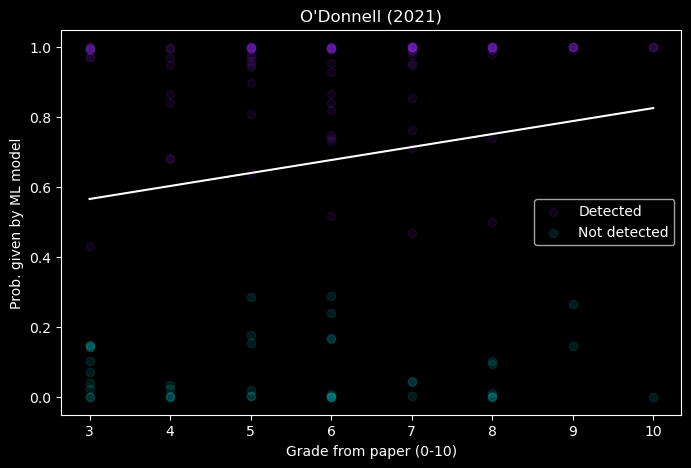

In [23]:
plt.figure(figsize=(8,5)) 

plt.title('O\'Donnell (2021)')
plt.xlabel('Grade from paper (0-10)')
plt.ylabel('Prob. given by ML model')
plt.scatter(right_data[names[3]], right_data[names[0]], color = 'blueviolet', alpha = 0.1, label ='Detected') #blueviolet
plt.scatter(wrong_data[names[3]], wrong_data[names[0]], color = 'cyan', alpha = 0.1, label = 'Not detected')
plt.plot(x, y, color='w')
plt.legend()

plt.show()

In [30]:
# Writes fit file
def write_fit_file(name, x, data):
    my_types = {'COADD_OBJECT_ID': int, 'TILENAME': str, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': int, 'IMAFLAGS_ISO_R': int, 'IMAFLAGS_ISO_I': int,
       'IMAFLAGS_ISO_Z': int, 'rank': float, 'num_sources': int, 'num_lenses': int, 'mem_match_id': float,
       'einstein_radius': float, 'einstein_radius_err': float, 'ACT': int, 'BBNA': int, 'BNA': int, 'TI': int,
       'RNA': int, 'RNA2': int, 'redM': int, 'redM_missed': int, 'SPTPol': int, 'Prob': float}
    data = data.astype(my_types)
    
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto(name + '.fits', overwrite=True)   
    hdu_list.close()

In [33]:
write_fit_file("Jack_recovered", images[0], right_data)